## Load DATA

In [26]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [27]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

In [28]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [29]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [30]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2019',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon'] #, 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [31]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    ft.AirQualityFeatures,
    ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    ft.GoogleTrendFeatures,
    ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    # ft.PopulationFeatures,
    ft.SportsCompetitionFeatures,
    ft.TrafficFeatures
    ]

In [32]:
# Select the target columns to be predicted
target_colomns = ['nb_emmergencies']
# target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [33]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [34]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [35]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14bce3340>),
                                ('pipelin...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14bce31f0>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14bce2ce0>)],
                  verbose=True)

In [36]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [37]:
features_config_get = {}

In [38]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon'],
    # 'locations': ['CHU Dijon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH privé Dijon'],
    'axis': 'rows',
    'shift': range(1, 8, 1),
    'rolling_window': [7, 14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': -3,
    'targets_rolling_window': 3,
    'targets_history_shifts': range(1, 8, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr': 1.0,
    'data_dir': root_dir / 'data'
    #'target_bins': [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0],
    # 'target_bins': [0, 0.3, 0.7, 1.0],
    #'replace_target': True,
    }

In [39]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-11-14 18:24:25,446: INFO: Initialisation de la classe BaseTabularDataset
root 2024-11-14 18:24:25,452: INFO: Initialisation des features
root 2024-11-14 18:24:25,454: INFO: Fetching data for hospitalfeatures at CHU Dijon
root 2024-11-14 18:24:25,656: INFO: Fetching data for airqualityfeatures at CHU Dijon
root 2024-11-14 18:24:25,829: INFO: Fetching data for epidemiologicalfeatures at CHU Dijon
root 2024-11-14 18:24:25,996: INFO: Fetching data for googletrendfeatures at CHU Dijon
root 2024-11-14 18:24:26,176: INFO: Fetching data for meteorologicalfeatures at CHU Dijon
root 2024-11-14 18:24:26,356: INFO: Fetching data for sociologicalfeatures at CHU Dijon
root 2024-11-14 18:24:26,536: INFO: Fetching data for sportscompetitionfeatures at CHU Dijon
root 2024-11-14 18:24:26,713: INFO: Fetching data for trafficfeatures at CHU Dijon
root 2024-11-14 18:24:27,078: INFO: Getting the dataset from 01-01-2019 to 30-12-2023 for [<src.location.location.Location object at 0x14bcc3d60>]
root

Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []


root 2024-11-14 18:24:27,560: INFO: Getting data for googletrendfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 18:24:27,618: INFO: Augmentation des features...


Dropped columns with zero variance: []


root 2024-11-14 18:24:28,328: INFO: Getting data for meteorologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 18:24:28,341: INFO: Augmentation des features...
root 2024-11-14 18:24:28,422: INFO: Getting data for sociologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 18:24:28,432: INFO: Augmentation des features...


Dropped columns with zero variance: []
Dropped columns with zero variance: []


root 2024-11-14 18:24:28,699: INFO: Getting data for sportscompetitionfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 18:24:28,705: INFO: Augmentation des features...
root 2024-11-14 18:24:28,720: INFO: Getting data for trafficfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-11-14 18:24:28,725: INFO: Augmentation des features...
root 2024-11-14 18:24:28,866: INFO: Creating the target columns as a rolling mean of nb_emmergencies_CHU Dijon on 3 rows shifted by -3
root 2024-11-14 18:24:28,869: INFO: Creating target history columns...
root 2024-11-14 18:24:28,871: WARNING: 1 as target history shift is not high enough considering that the target is shifted and/or is a rolling mean,                                            
target_history_shift value will be set to 1 + abs(targets_shift) + targets_rolling_window
root 2024-11-14 18:24:28,873: WARNING: 2 as target history shift is not high enough considering tha

Dropped columns with zero variance: []
Dropped columns with zero variance: []


root 2024-11-14 18:24:28,932: INFO: Calculating train/val/test sets and encodings...


Column 'PM10_FR26010' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26094' is constant at 19.0 for 100.00% of the rows.
Column 'PM25_FR26094' is constant at 6.8 for 100.00% of the rows.
Column 'NO2_FR26010' is constant at 6.9 for 100.00% of the rows.
Column 'NO2_FR26094' is constant at 7.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-1' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-2' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-3' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-4' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-5' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-6' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%J-7' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%mean_7J' is constant at 15.0 for 100.00% of the rows.
Column 'PM10_FR26010%%std_7J' is constant at 0.0 for 100.00% of the rows.
Column 'PM10_FR2

In [40]:
df = arsTabularDataset.enc_data.copy(deep=True)

In [41]:
df

,O3_FR26005,O3_FR26010,PM10_FR26005,PM10_FR26014,PM25_FR26005,NO2_FR26005,NO2_FR26014,O3_FR26005%%J-1,O3_FR26005%%J-2,O3_FR26005%%J-3,...,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-11,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_365J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std365J%%J-6
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.178403,0.101405,0.532649,0.330745,0.066912,0.326464,0.721612,0.281023,-0.805563,-1.221684,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-04,-0.554787,-0.195616,0.396244,0.330745,0.797608,0.975668,1.335628,-0.179023,0.281523,-0.803836,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-05,-0.638428,-0.704794,0.123434,0.198923,0.627679,0.196623,0.353202,-0.555424,-0.178398,0.282569,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-06,-0.303864,-0.365342,-0.285782,-0.460184,0.304813,-0.322741,-0.506421,-0.639068,-0.554697,-0.177064,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-07,-0.722068,-0.535068,0.396244,0.198923,0.627679,0.975668,0.967218,-0.304490,-0.638319,-0.553127,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,-0.554787,-0.450205,-0.558592,-0.460184,-0.120010,0.326464,0.721612,-1.768272,-1.725405,-1.347039,...,175.333333,177.666667,175.095238,7.910879,179.690476,10.341572,179.655914,9.812118,176.619178,13.992984
2023-12-21,-0.052941,0.101405,-1.377023,-1.119292,-0.680777,-0.530487,-0.015208,-0.555424,-1.767216,-1.723102,...,182.666667,185.000000,174.809524,7.430810,180.952381,9.780372,179.408602,9.566806,176.581735,13.952051
2023-12-22,0.574365,0.355994,-1.104213,-0.987470,-0.731756,-0.738232,0.721612,-0.053556,-0.554697,-1.764887,...,168.333333,184.000000,176.047619,8.213423,181.785714,9.481973,179.569892,9.601772,176.543379,13.912195


## Trend prediction

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import List, Tuple

In [43]:
def categorize(df, column, bins=[0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0], labels=None, drop=False, offset=0):
    if labels == None and type(bins) == int:
        labels = [f'{i+offset}' for i in range(bins)]
    elif labels == None and type(bins) == list:
        labels = [f'{i+offset}' for i in range(len(bins) - 1)]
    col_category = (column if drop else f'{column}_category')
    df[col_category] = pd.qcut(df[column], q=bins, labels=labels)
    return df

In [44]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [3, 4, 5, 6, 7, 8, 9]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=False)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)
            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=False)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = bst.predict(dtest)
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Calendaire

In [45]:
df = df.drop(df.loc['2020-03':'2020-05'].index)

target = arsTabularDataset.targets_names[0]

# y = df[target]
y = arsTabularDataset.data[target]
y = y.drop(y.loc['2020-03':'2020-05'].index)
result = seasonal_decompose(y, model='additive', period=7)

#df = df0.copy()
df0 = arsTabularDataset.data.copy(deep=True)
df['target'] = result.trend.copy()
df.dropna(inplace=True)
df = categorize(df, 'target', bins=5, drop=True, offset=1)
df['target'] = df['target'].astype(float)


In [46]:
df0

,nb_emmergencies,nb_emmergencies%%J-1,nb_emmergencies%%J-2,nb_emmergencies%%J-3,nb_emmergencies%%J-4,nb_emmergencies%%J-5,nb_emmergencies%%J-6,nb_emmergencies%%J-7,nb_emmergencies%%mean_7J,nb_emmergencies%%std_7J,...,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-11,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_365J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std365J%%J-6
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,186,198.0,202.0,200.0,186.0,238.0,202.0,191.0,202.428571,16.791438,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-04,186,186.0,198.0,202.0,200.0,186.0,238.0,202.0,201.714286,17.451975,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-05,204,186.0,186.0,198.0,202.0,200.0,186.0,238.0,199.428571,18.428756,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-06,182,204.0,186.0,186.0,198.0,202.0,200.0,186.0,194.571429,8.223080,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
2019-01-07,194,182.0,204.0,186.0,186.0,198.0,202.0,200.0,194.000000,9.018500,...,189.666667,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,183,185.0,165.0,148.0,193.0,164.0,191.0,171.0,173.857143,16.516947,...,175.333333,177.666667,175.095238,7.910879,179.690476,10.341572,179.655914,9.812118,176.619178,13.992984
2023-12-21,187,183.0,185.0,165.0,148.0,193.0,164.0,191.0,175.571429,16.791438,...,182.666667,185.000000,174.809524,7.430810,180.952381,9.780372,179.408602,9.566806,176.581735,13.952051
2023-12-22,182,187.0,183.0,185.0,165.0,148.0,193.0,164.0,175.000000,16.237816,...,168.333333,184.000000,176.047619,8.213423,181.785714,9.481973,179.569892,9.601772,176.543379,13.912195


In [47]:
# dg0 = df0.copy()
# dg0['resid'] = result.resid
# dg0.drop('target', axis=1, inplace=True)
# dg0.rename({'resid': 'target'}, axis=1, inplace=True)
# dg0.dropna(inplace=True)
# dg0['target'] = dg0['target'].apply(lambda x: 1 if x > 0 else 0)

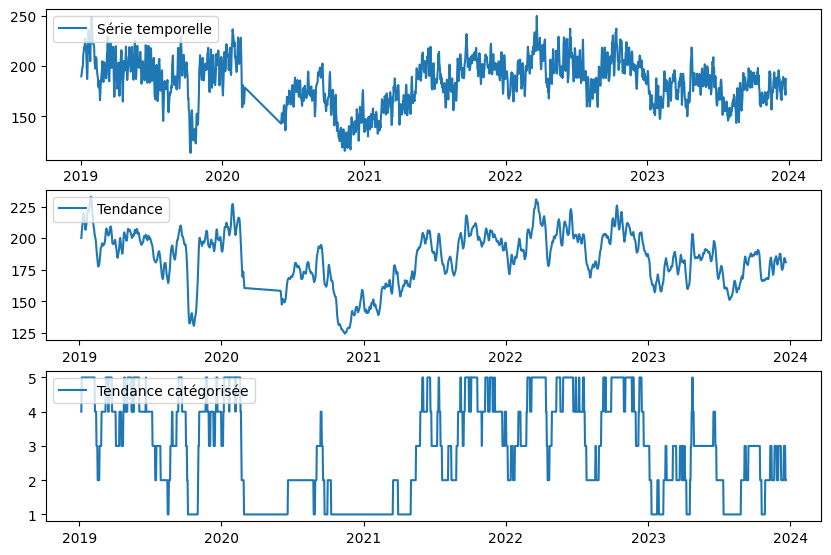

In [48]:
# Affichage des composantes
plt.figure(figsize=(10, 9))
plt.subplot(411)
plt.plot(y, label='Série temporelle')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Tendance')
plt.legend(loc='upper left')


# print(df['target'])
ax3 = plt.subplot(413)  # Capture the Axes for the third subplot
plt.plot(df['target'], label='Tendance catégorisée')
ax3.set_ylim(sorted(ax3.get_ylim()))  # Corrects the order of y-axis with 0 at the bottom
plt.legend(loc='upper left')

# plt.subplot(413)
# plt.plot(result.seasonal, label='Saisonnalité')
# plt.legend(loc='upper left')

# plt.subplot(414)
# plt.plot(result.resid, label='Résidu')
# plt.legend(loc='upper left')
# plt.tight_layout()
plt.show()

In [49]:
df

,O3_FR26005,O3_FR26010,PM10_FR26005,PM10_FR26014,PM25_FR26005,NO2_FR26005,NO2_FR26014,O3_FR26005%%J-1,O3_FR26005%%J-2,O3_FR26005%%J-3,...,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std7J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std14J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std31J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%mean_365J%%J-6,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%std365J%%J-6,target
date,,,,,,,,,,,,,,,,,,,,,
2019-01-06,-0.303864,-0.365342,-0.285782,-0.460184,0.304813,-0.322741,-0.506421,-0.639068,-0.554697,-0.177064,...,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,4.0
2019-01-07,-0.722068,-0.535068,0.396244,0.198923,0.627679,0.975668,0.967218,-0.304490,-0.638319,-0.553127,...,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,5.0
2019-01-08,-0.680248,-0.492636,-0.012971,-0.064720,0.236841,0.845828,0.967218,-0.722713,-0.303831,-0.636697,...,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,5.0
2019-01-09,0.197981,0.228699,-0.558592,-0.723827,-0.544834,0.066782,0.230399,-0.680891,-0.721941,-0.302418,...,189.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,5.0
2019-01-10,-0.512966,-0.280479,0.123434,-0.196541,0.015933,0.456305,0.844415,0.197378,-0.680130,-0.720267,...,192.666667,200.095238,9.050710,209.500000,12.225621,215.806452,16.135485,192.633790,21.963898,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17,-1.349375,-1.341266,0.396244,0.462566,0.967538,0.196623,0.107596,-0.973647,-1.599972,-0.720267,...,168.333333,184.523810,9.960770,182.833333,9.037198,181.666667,9.820236,176.928767,14.269165,3.0
2023-12-18,-1.725759,-2.147465,-0.149377,0.198923,0.627679,0.715987,0.476005,-1.350048,-0.972807,-1.597748,...,168.666667,180.666667,10.152540,181.571429,9.718630,181.010753,9.991657,176.814612,14.167497,3.0
2023-12-19,-1.767580,-2.147465,-0.422187,-0.064720,0.627679,0.845828,0.476005,-1.726449,-1.349106,-0.970975,...,166.000000,176.571429,9.310914,179.976190,10.336612,180.086022,10.012203,176.694977,14.073377,3.0


Amélioration avec max_depth=3: 100000.0000 -> 1.1582


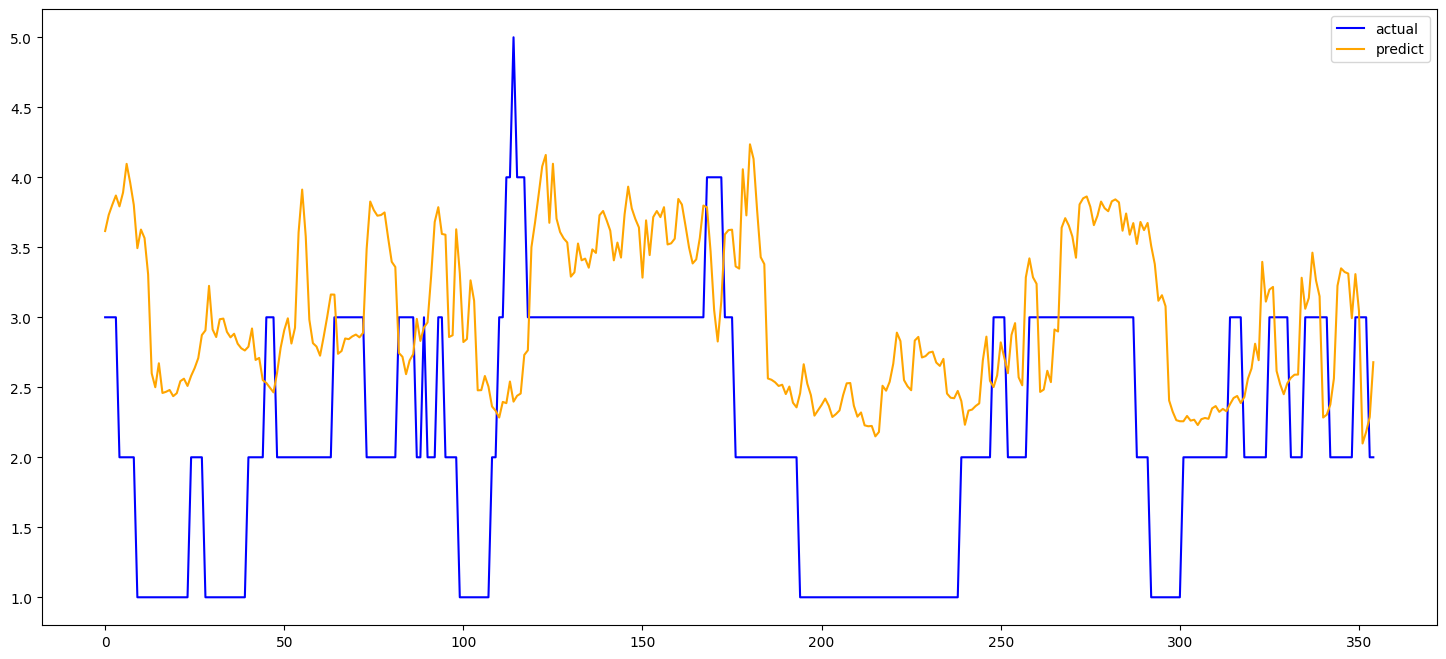

0.00%,1%
0.00%,2%
0.56%,3%
1.13%,4%
1.41%,5%
1.97%,6%
3.38%,7%
3.94%,8%
4.23%,9%
5.07%,10%
6.20%,11%
   - MAE : 0.89 (0.99 sur 2023)
   - MSE : 1.16 (1.33 sur 2023)


KeyboardInterrupt: 

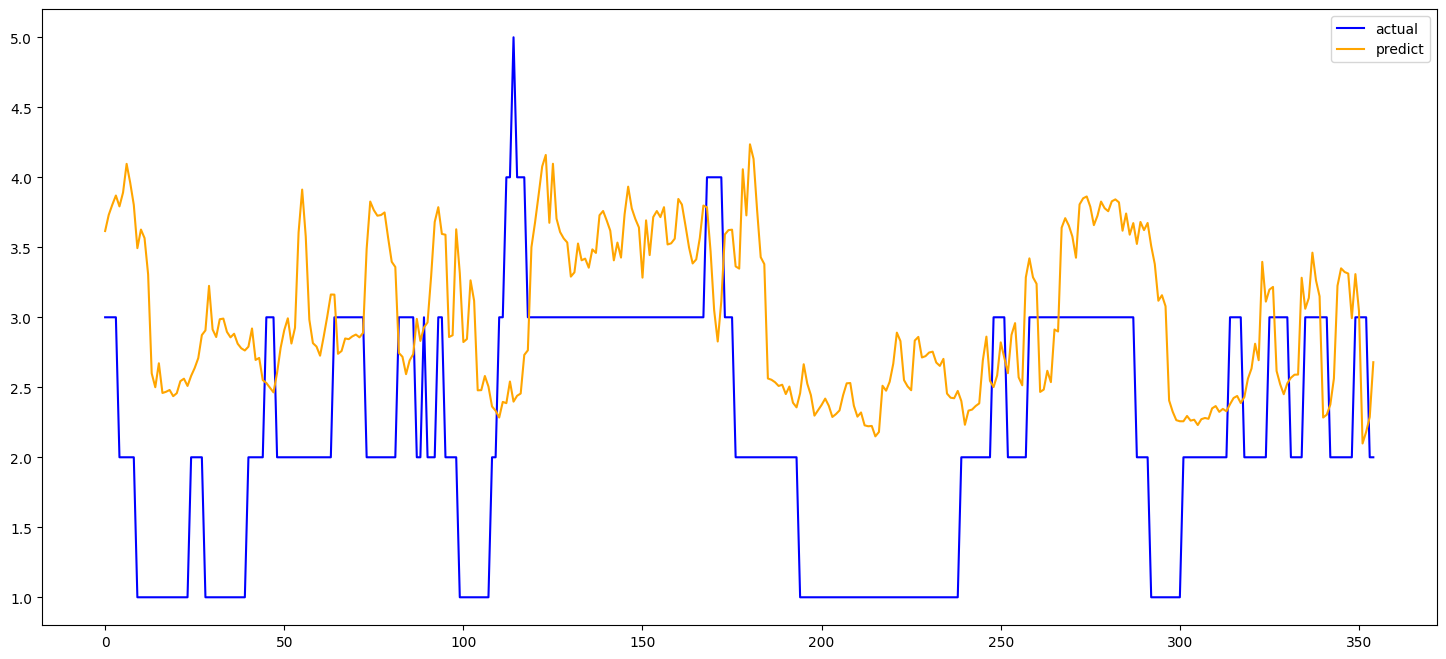

In [50]:
params = {'eta': 0.05, 
          'objective': 'reg:squarederror', 
          'eval_metric': ['rmse', 'mae'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1,
          'device':'cpu'}

score = 100000
# cols = ['dayofYear', 'month']
# col = "holidays"
# new_score, _ = teste(df[cols+[col, 'target']], params, score=score)
new_score, reg = teste(df, params, score=score)

In [ ]:
df0

,trend_maladie%%std_31J,trend_chute%%mean_365J,meteo_tmin%%J-7,trend_infection cutanée%%std_14J,trend_noyade%%std_31J,trend_SAMU%%mean_365J,trend_hypothermie%%std_7J,inc_ira%%J-6,trend_asphyxie%%J-1,trend_pneumonie%%mean_7J,...,trend_angine%%mean_365J,trend_douleur%%std_14J,trend_entorse,eveBankHolidays%%J-3,trend_empoisonnement%%std_365J,target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-7,trend_noyade%%mean_14J,trend_étourdissements%%J-7,trend_pneumonie%%mean_31J,nb_accidents
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,13.151393,1.915068,4.4,0.000000,11.85395,0.432877,0.0,0.0,0.0,12.0,...,0.090411,13.193405,0.0,False,3.978022,189.666667,4.714286,0.0,2.709677,0.0
2019-01-04,13.151393,1.915068,4.4,0.000000,11.85395,0.432877,0.0,0.0,0.0,12.0,...,0.090411,13.193405,0.0,False,3.978022,189.666667,4.714286,0.0,2.709677,0.0
2019-01-05,13.151393,1.915068,4.4,0.000000,11.85395,0.432877,0.0,0.0,0.0,12.0,...,0.090411,13.193405,0.0,False,3.978022,189.666667,4.714286,0.0,2.709677,0.0
2019-01-06,13.151393,1.915068,4.4,0.000000,11.85395,0.432877,0.0,0.0,0.0,12.0,...,0.090411,13.193405,0.0,False,3.978022,189.666667,4.714286,0.0,2.709677,1.0
2019-01-07,13.151393,1.915068,4.4,0.000000,11.85395,0.432877,0.0,0.0,0.0,12.0,...,0.090411,13.193405,0.0,False,3.978022,189.666667,4.714286,0.0,2.709677,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-20,16.494444,7.841096,7.5,20.044593,0.00000,0.180822,0.0,5971.0,0.0,0.0,...,0.690411,15.147807,0.0,False,6.730867,166.000000,0.000000,0.0,0.000000,0.0
2023-12-21,16.060035,7.841096,5.9,20.044593,0.00000,0.180822,0.0,5971.0,0.0,0.0,...,0.635616,15.107127,0.0,False,6.730867,177.666667,0.000000,0.0,0.000000,0.0
2023-12-22,16.131849,7.841096,2.5,20.044593,0.00000,0.180822,0.0,5971.0,0.0,0.0,...,0.635616,15.369443,0.0,False,6.730867,185.000000,0.000000,0.0,0.000000,0.0


MAE: 18.04


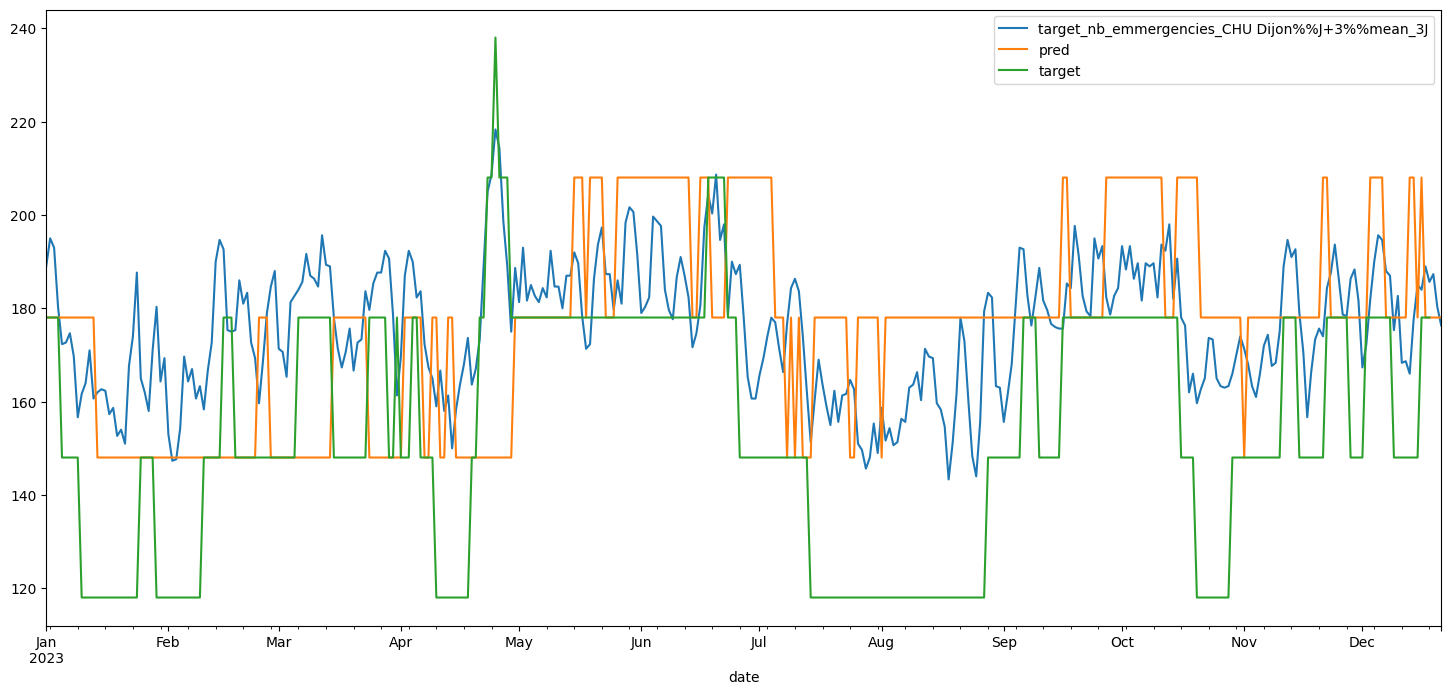

In [ ]:
dg = df0.loc[df0.index.year == 2023][:-3]
dh = df.loc[df.index.year == 2023].drop(columns='target')
print(target)
dg['pred'] = reg.predict(xgb.DMatrix(dh)).round(0) * 30 + dg[target].mean()/2
fig, ax = plt.subplots()
dg.plot(y=[target, 'pred'], ax=ax)
(df.loc[df.index.year == 2023, ['target']][:-3] * 30 + dg[target].mean()/2).plot(ax=ax)
print(f"MAE: {mean_absolute_error(dg[target], dg['pred']):.2f}")

In [ ]:
# Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
importance_gain = reg.get_score(importance_type='gain')
importance_cover = reg.get_score(importance_type='cover')
importance_weight = reg.get_score(importance_type='weight')

df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

di = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
di.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

di = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
di.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

di['gain_norm'] = di['gain'] / di['gain'].sum()
di['cover_norm'] = di['cover'] / di['cover'].sum()
di['weight_norm'] = di['weight'] / di['weight'].sum()

w_gain = 0.5
w_cover = 0.3
w_weight = 0.2

di['importance'] = (di['gain_norm'] * w_gain) + (di['cover_norm'] * w_cover) + (di['weight_norm'] * w_weight)

di.sort_values(by='importance', ascending=False, inplace=True)
di['rank'] = di['importance'].rank(ascending=False)

di.reset_index(inplace=True)
di.rename(columns={'index': 'feature'}, inplace=True)
print(di[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']])


                                               feature        gain  \
0    target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...  448.663513   
1    target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...  230.398926   
2                          trend_appendicite%%std_365J  126.057816   
3    target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J...  105.515884   
4                                        foot%%std_31J   57.028812   
..                                                 ...         ...   
147                              inc_diarrhee%%std_31J    0.312707   
148                                  inc_diarrhee%%J-7    0.037937   
149                             PM10_FR26014%%mean_14J    0.070792   
150                                  PM10_FR26014%%J-7    0.222466   
151                                   NO2_FR26005%%J-2    0.087790   

          cover  weight  importance   rank  
0    749.533325    15.0    0.113717    1.0  
1    589.500000     4.0    0.059647    2.0  
2    611.230774    13.0 